<a href="https://colab.research.google.com/github/jason-zl190/deeplearning/blob/master/test_mask_bbox_convertible.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

TensorFlow 2.x selected.


In [0]:
from matplotlib import patches

# **Numpy way to draw bbox**

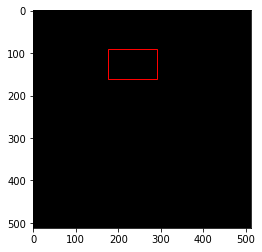

In [0]:
ones = np.ones([512,512])
bbox = [226.169-50, 90.0204, 241.252+50, 111.977+50]
xmin, ymin, xmax, ymax = bbox
h = xmax-xmin
w = ymax-ymin
fig,ax = plt.subplots(1)
ax.imshow(ones, cmap='gray')

rect = patches.Rectangle((xmin, ymin),h,w,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

plt.show()

# mask and bbox convert function

In [0]:
def _convert_bbox_to_mask(bbox, image_shape):
    """generate a 2-d binary mask, all zeros except the bbox area
      
      bbox: [xmin, ymin, xmax, ymax]
      image_shape: [height, width, depth], depth will be ignored
      
      return:
        2-d binary mask, zero-initialized
    """
    # numpy version: mask[ymin:ymax+1][xmin:xmax+1][:] = 1
    xmin = tf.cast(tf.math.round(bbox[0]), dtype=tf.int32)
    ymin = tf.cast(tf.math.round(bbox[1]), dtype=tf.int32)
    xmax = tf.cast(tf.math.round(bbox[2]), dtype=tf.int32)
    ymax = tf.cast(tf.math.round(bbox[3]), dtype=tf.int32)
    
    r_range = tf.range(xmin, xmax)
    c_range = tf.range(ymin, ymax)
    mesh = tf.meshgrid(r_range, c_range)
    i_coords, j_coords = mesh
    
    indices = tf.stack([j_coords,i_coords], axis=2)
    indices = tf.reshape(indices, [tf.size(i_coords),2])
    updates = tf.ones(tf.size(i_coords), dtype=tf.int64)
    
    r = image_shape[0]
    c = image_shape[1]
    shape = [r, c]
    mask = tf.scatter_nd(indices, updates, shape)
#     mask = tf.tile(mask, [l,1])
#     mask = tf.reshape(mask, [l,r,c])
#     mask = tf.transpose(mask, [1, 2, 0])
    
    return mask    
    
    
def _convert_mask_to_bbox(mask):
    """find out the bbox postion inside the mask
    """
    ymin = tf.where(mask)[:,0][0]
    ymax = tf.where(mask)[:,0][-1]
    xmin = tf.where(mask)[:,1][0]
    xmax = tf.where(mask)[:,1][-1]
    return [xmin, ymin, xmax, ymax]
  

    
def _convert_bbox_to_offset(bbox):
    """convert the data format
    
      Params:
        bbox: [xmin, ymin, xmax, ymax]
      return:
        offset: [offset_height=ymin, offset_width=xmin, 
                 target_height=ymax - ymin, target_width=xmax - xmin]
      
    """
    xmin = tf.cast(tf.math.round(bbox[0]), dtype=tf.int32)
    ymin = tf.cast(tf.math.round(bbox[1]), dtype=tf.int32)
    xmax = tf.cast(tf.math.round(bbox[2]), dtype=tf.int32)
    ymax = tf.cast(tf.math.round(bbox[3]), dtype=tf.int32)
    
    offset_height = ymin
    offset_width = xmin
    target_height = ymax - ymin
    target_width = xmax - xmin
    
    return [offset_height, offset_width, target_height, target_width]
  

def _convert_offset_to_bbox(offset):
    """convert the data format
    
      Params:
        offset: [offset_height, offset_width, target_height, target_width]
      return:
        bbox: [xmin=offset_width, ymin=offset_height, 
               xmax=target_width + offset_width, ymax=target_height + offset_height]
      
    """
    offset_height = offset[0]
    offset_width = offset[1] 
    target_height = offset[2]
    target_width = offset[3]
    
    ymin = offset_height
    xmin = offset_width
    ymax = target_height + offset_height
    xmax = target_width + offset_width
    
    return [xmin, ymin, xmax, ymax]

# Visualization

In [0]:
ones = np.ones([512,512])
bbox = [226.169-50, 90.0204, 241.252+50, 111.977+50]
bbox_tf = tf.constant(bbox)

image = tf.convert_to_tensor(ones, np.float32)
mask = _convert_bbox_to_mask(bbox_tf, [512, 512])
mask = tf.cast(mask, tf.float32)

stack = tf.stack([image, mask])
stack_t = tf.keras.preprocessing.image.random_shear(stack, 30)

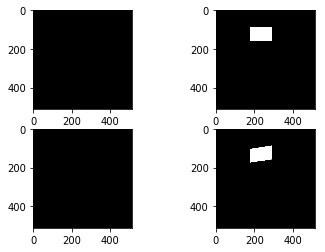

In [0]:
fig,ax = plt.subplots(2, 2)
ax[0][0].imshow(ones, cmap='gray')
ax[0][1].imshow(mask, cmap='gray')
ax[1][0].imshow(stack_t[0], cmap='gray')
ax[1][1].imshow(stack_t[1], cmap='gray')

In [0]:
mask_t = stack_t[1]
bbox_t = _convert_mask_to_bbox(mask_t)

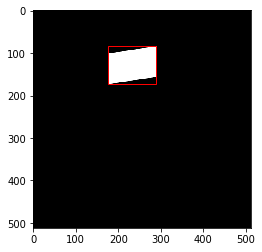

In [0]:
xmin, ymin, xmax, ymax = bbox_t
xmin = xmin.numpy()
ymin = ymin.numpy()
xmax = xmax.numpy()
ymax = ymax.numpy()
h = xmax-xmin
w = ymax-ymin
fig,ax = plt.subplots(1)
ax.imshow(stack_t[1], cmap='gray')
rect = patches.Rectangle((xmin, ymin),h,w,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

plt.show()